<a href="https://colab.research.google.com/github/bejide-ux/alx/blob/main/Final_Soil_organic_Carbon_sequestration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
geeproject='ee-bejidedavid37'



### DO NOT CHANGE below !!





#install libraries
!pip install geopandas
!pip install pycrs #this has to be always installed..
!pip install rasterio
!pip install plotly==5.24.1

import geemap
import ee
import os
import pycrs
import geemap.colormaps as cm
import geopandas as gpd
import glob
from osgeo import gdal

# Import rasterio and numpy for the export function
import rasterio
from rasterio.transform import Affine
from rasterio.transform import from_bounds
import numpy as np
import os # Import os module


def export_array_to_geotiff(exportingarray, output_file='exportingarray.tif', output_dir=None, lon=None, lat=None, res=None): # Added lon, lat, res parameters

  # geobounds = aoigeo.bounds.getInfo() # Removed this line
  # print(geobounds)

  if output_dir:
      # Create the output directory if it doesn't exist
      os.makedirs(output_dir, exist_ok=True)
      # Construct the full output path
      full_output_path = os.path.join(output_dir, output_file)
  else:
      # If output_dir is not specified, use the directory of the output_file
      # If output_file is just a filename, it will be saved in the current directory
      full_output_path = output_file


  # --- Added diagnostic print statements ---
  print(f"Attempting to save to: {full_output_path}")
  # Check if the directory part of the full_output_path exists if output_dir was not provided
  output_directory_for_check = os.path.dirname(full_output_path) if os.path.dirname(full_output_path) else '.'
  if os.path.exists(output_directory_for_check):
      print(f"Output directory exists: {output_directory_for_check}")
  else:
      print(f"Output directory does NOT exist: {output_directory_for_check}")
  # --- End of diagnostic print statements ---


  # Assuming 'aoigeo' is globally available or passed to the function
  # If aoigeo is not available, you might need to calculate bounds differently
  # For now, relying on the existing aoigeo variable
  # bounds = aoigeo.bounds

  # Get bounding box coordinates using individual attributes
  # min_lon = bounds.minx
  # min_lat = bounds.miny
  # max_lon = bounds.maxx
  # max_lat = bounds.maxy


  # print(min_lon, max_lon)
  # print(min_lat, max_lat)


  rows, cols = exportingarray.shape

  # x = np.linspace(min_lon, max_lon, cols)
  # y = np.linspace(max_lat - yres * (rows - 1), max_lat, rows) # Corrected y calculation
  # X, Y = np.meshgrid(x, y)
  # xres = (x[-1] - x[0]) / len(x)
  # xres
  # yres = (y[-1] - y[0]) / len(y)
  # yres

  # Calculate transform using provided lon, lat, and res
  if lon is not None and lat is not None and res is not None:
      transform = Affine.translation(lon, lat) * Affine.scale(res, -res) # Negative res for latitude to go from top to bottom
  else:
      # Fallback if lon, lat, res are not provided (you might want a different default behavior or error handling)
      # For now, keeping the previous logic if lon, lat, res are not provided
      # This part might need adjustment based on how the function is intended to be used in other places
      if 'aoigeo' in globals(): # Check if aoigeo is defined
          bounds = aoigeo.bounds
          min_lon = bounds.minx
          max_lat = bounds.maxy
          xres = (bounds.maxx - min_lon) / cols
          yres = (bounds.maxy - bounds.miny) / rows * -1 # Negative to go from top to bottom
          transform = Affine.translation(min_lon, max_lat) * Affine.scale(xres, yres)
      else:
          # Handle case where neither lon/lat/res nor aoigeo is available
          raise ValueError("Georeferencing information (lon, lat, res or aoigeo) not provided.")



  # print(transform)

  height=exportingarray.shape[0]



  with rasterio.open(
     full_output_path, # Use the full output path
     'w',
     driver='GTiff',
     height=exportingarray.shape[0],
     width=exportingarray.shape[1],
     count=1,
     dtype=exportingarray.dtype,
     crs='+proj=latlong', # Use a CRS string compatible with your data, e.g., 'EPSG:4326' if in WGS84
     transform=transform,
  ) as dst:
      dst.write(exportingarray, 1)

  # Removed files.download() as we are saving to a specified path
  # from google.colab import files
  # files.download(full_output_path)



# Authenticate
ee.Authenticate()






#Initialize Project
ee.Initialize(project=geeproject) ##change here to your own project

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=c6b9a9d2bbaad84aee9cbfa74a7149d02a98709b534c57285d33fb45942cc782
  Stored in directory: /root/.cache/pip/wheels/b5/4a/72/1ba05f57ddf2cc80ad21a26512097762561d646ff3ff85f729
Successfully built pycrs
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 79.7 MB/s eta 0:00:00


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the required datasets


In [4]:
# aoi =
# aoi

## data collection

bd = ee.Image("projects/ee-bejidedavid37/assets/Bdod_losllanos_0_100cm")
cdi = ee.Image("projects/ee-bejidedavid/assets/CDI_annual_mean1")
clay = ee.Image("projects/ee-bejidedavid/assets/Clay_Stacked")

#silt = ee.Image("projects/ee-bejidedavid37/assets/SILT")
#To get silt, we will estimate it using the soil composition formular below
#Silt+Clay+Sand = 100
#Silt = 100- Clay - sand

soc = ee.Image("projects/ee-bejidedavid/assets/SOC_stack1")
sand_stacked= ee.Image("projects/ee-bejidedavid/assets/Sand_Stacked")

silt = ee.Image(100).subtract(clay).subtract(sand_stacked)


#Soil organic carbon
shp_path = ee.FeatureCollection('projects/ee-bejidedavid/assets/Carbon_stock')

llanos_shp = ee.FeatureCollection('projects/ee-bejidedavid/assets/Departamentos_Orinoquia_WGS84')

print(silt.getInfo())

#Since this is not the final data, we will export available data from PC and stack them here when necessary. However, i will upload as asset when the final data is read

{'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [28415, 23517], 'crs': 'EPSG:32717', 'crs_transform': [30, 0, 1167175.4662905, 0, -30, 10831900.0209542]}, {'id': 'b2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [28415, 23517], 'crs': 'EPSG:32717', 'crs_transform': [30, 0, 1167175.4662905, 0, -30, 10831900.0209542]}]}


In [5]:
#checkinmg resolution#
print('Resolution silt map: ', silt.projection().nominalScale().getInfo(),'; Resolution clay map:', clay.projection().nominalScale().getInfo(),
 '; Resolution soc map:', soc.projection().nominalScale().getInfo(), '; Resolution cdi map:', cdi.projection().nominalScale().getInfo() )

Resolution silt map:  30 ; Resolution clay map: 30 ; Resolution soc map: 30 ; Resolution cdi map: 927.6624232772793


Define here:
- coordinate system
- scale
- aoi

In [6]:
import geopandas as gpd
import os

# Define the path to the exported GeoJSON file in your Google Drive
# This path assumes the file is in a folder named 'ee-exports' at the root of your Drive
# geojson_path = '/content/drive/My Drive/ee-exports/aoi.geojson' # Comment out or remove this line as we are using an EE asset

# Use the Earth Engine asset directly
# aoi = ee.FeatureCollection('projects/ee-bejidedavid/assets/Carbon_stock') # Comment out this line

# Use the llanos_shp as the aoi
aoi = llanos_shp


# Since 'aoi' is now an EE object, we don't need geopandas here
# We also don't need to reproject an EE FeatureCollection if its CRS is already suitable for EE (usually WGS84)

# You can print information about the EE FeatureCollection if needed
print("AOI Earth Engine FeatureCollection loaded successfully.")
print("AOI info:", aoi.getInfo())

# For processing steps that require a GeoPandas object, you would need to export the EE FeatureCollection first,
# but for clipping EE images, the EE FeatureCollection is sufficient.
# If you still need a GeoPandas object for other purposes, you would export the 'aoi' EE object and read it.

# aoigeo = aoi.geometry # This is not directly applicable to an EE FeatureCollection

AOI Earth Engine FeatureCollection loaded successfully.
AOI info: {'type': 'FeatureCollection', 'columns': {'AREA_HA': 'Float', 'Name': 'String', 'Shape_Leng': 'Float', 'system:index': 'String'}, 'version': 1757431246166865, 'id': 'projects/ee-bejidedavid/assets/Departamentos_Orinoquia_WGS84', 'properties': {'system:asset_size': 469700}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-72.36662169569415, 6.306890084987142], [-72.36634965669688, 6.306698347934641], [-72.3658413440599, 6.306230181866601], [-72.36548910127293, 6.305802044717526], [-72.36529283862058, 6.304669454931555], [-72.36524831145526, 6.303304965591531], [-72.36513234209006, 6.30221253877123], [-72.36473990645115, 6.301940516369109], [-72.36411119538462, 6.300847988697601], [-72.36348248287248, 6.2982750948174155], [-72.3629652232688, 6.294765823505894], [-72.3627690491245, 6.293517229728378], [-72.3625727845198, 6.29277707525113], [-72.36264865304453, 6.291956554940402], [-72.3626

In [7]:
### check layers
# silt
# cdi
# clay
# soc
bd
# aoi
#FF


Now we clip our data to make processing faster.  In case you use another data, you can easily adjust here the code.
If you have e.g. data for fine fraction already in one Image (and not as in this example in two: silt and clay), then just clip your fine fraction image here as e.g.:

ffclip = ff.clip(aoi)

Remove or add thus layers, depening on what you have.

These clipped images will be the base for the PCA. If you add another image in the clipping section, you need to add/adjust it also in the PCA section. See PCA of Fine Fraction for an example how to adjust the input there in case.

In [8]:
import geemap.colormaps as cm


vis_cdi = {
    "min": 0.1692744642496109,
    "max": 0.2419,
    "palette": ["#0000ff", "#ff0000", "#ffff00", "#008000"],}




vis_soc_dgkg = {
    "min": 10,
    "max": 43,
    "palette": ["#0000ff", "#ff0000", "#ffff00", "#008000"],
                }

vis_clay = {
    "min": 12,
    "max": 42,
    "palette": ["#0000ff", "#ff0000", "#ffff00", "#008000"],
                }

vis_soc_tonha = {
    "min": 10.6,
    "max": 26.7,
    "palette": ["#0000ff", "#ff0000", "#ffff00", "#008000"],
                }

vis_silt = {
    "min":15,
    "max":52,
    "palette": ["#0000ff", "#ff0000", "#ffff00", "#008000"],
}

vis_bdod = {
    "min": 97,
    "max": 148,
    "palette": ["#0000ff", "#ff0000", "#ffff00", "#008000"],}

# cm.list_colormaps() #to see what palettes there are

#getting value range
stat_dict = cdi.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
)


min_max_values = stat_dict.getInfo()
print("Min-/Max-Werte:", min_max_values)

Min-/Max-Werte: {'b1_max': 0.2513156235218048, 'b1_min': 0.14509697258472443}


In [9]:
# clipping to aoi


socclip = soc.clip(aoi)
siltclip = silt.clip(aoi)
clayclip = clay.clip(aoi)
cdiclip = cdi.clip(aoi)
bdclip = bd.clip(aoi)


print("clayclip: ", clayclip.bandNames().getInfo())   # in case you want to know the band names
print("socclip :", socclip.bandNames().getInfo())
print("siltclip :", siltclip.bandNames().getInfo())
print("cdiclip :", cdiclip.bandNames().getInfo())
print("bdclip :", bdclip.bandNames().getInfo())

clayclip:  ['b1', 'b2']
socclip : ['b1', 'b2']
siltclip : ['b1', 'b2']
cdiclip : ['b1']
bdclip : ['bdod_0_30', 'bdod_30_100']


In [10]:
# #visualize just for first impression

map = geemap.Map()
map.add_layer(socclip.select(['b1']), vis_soc_dgkg, "socclip")
map.add_layer(clayclip.select(['b1']), vis_clay, "clayclip")
map.add_layer(siltclip.select(['b1']), vis_silt, "siltclip")
map.add_layer(cdiclip.select(['b1']), vis_cdi, "cdiclip")
map.add_layer(bdclip.select(['bdod_0_30']), vis_bdod, "bdclip") # Added bdclip visualization
map.centerObject(aoi, zoom=7) # Changed ee_aoi to aoi
display(map)

Map(center=[4.5482948960486755, -71.14217684544856], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
def boundaryline (chosen_percentil = 3, export = True):






  selected_BLpercentage = grouped_descriptions[[str(f"{int(percentiles[chosen_percentil]*100)}%")]]



  # selected_BLpercentage['Cluster'] = list(range(len(selected_BLpercentage.index)))
  selected_BLpercentage['Cluster'] = selected_BLpercentage.index
  print(selected_BLpercentage.head())


  #includes our BLA information of each cluster


  import numpy as np
  import pandas as pd
  import matplotlib as mpl
  !pip install rasterio
  import rasterio
  import matplotlib.pyplot as plt # Import pyplot


  # our raster we want to update with new SOC data: aoi_r
  # aoi_r = rasterio.open(raster_path) # This is already opened outside the function
  aoi_r_array = aoi_r.read(1)



  columns_with_percent = [col for col in selected_BLpercentage.columns if '%' in col]

  clustersocdict = selected_BLpercentage.set_index('Cluster')[columns_with_percent].to_dict()



  main_key = list(clustersocdict.keys())[0]

  clusterdic = clustersocdict[main_key]


  aoi_r_array_copy = np.copy(aoi_r_array)
  for cluster, soc in clusterdic.items():
      aoi_r_array_copy[aoi_r_array_copy == cluster] = soc

  oscmaxbl = aoi_r_array_copy


  fig, ax = plt.subplots()
  img = mpl.pyplot.imshow(oscmaxbl)
  ax.set_aspect("auto")
  ax.set_title(f"Max SOC [ton/ha] per CLZ - BLA {int(percentiles[chosen_percentil]*100)}%. Used model: {modelused}")
  plt.colorbar(img)

## EXPORTING. NO NEED TO CHANGE
  if export is True:
    # Get transform from the rasterio dataset
    transform = aoi_r.transform
    # Calculate lon, lat, and resolution from the transform
    # Use the export function from cell LNx51p_MVSvz which includes lon, lat, res parameters
    # Removed the incorrect import statement
    # from LNx51p_MVSvz import export_array_to_geotiff
    export_array_to_geotiff(exportingarray=oscmaxbl, output_file=f"{modelused}_{int(percentiles[chosen_percentil]*100)}_maxSOC.tif", lon=transform.c, lat=transform.f, res=transform.a)

In [19]:
## DONT CHANGE THIS SNIPPET !!!!!!
















## PCA function converted to python api as from (https://www.lifeingis.com/computation-of-principal-component-analysis-in the-google-earth-engine/  [last visited: 16/12/2024])

def PCA(maskedImage):


  image = maskedImage.unmask()
  scale_reduce = 5000 # Increased scale for reduceRegion
  region = aoi # Changed ee_aoi to aoi
  bandNames = image.bandNames()

  meanDict = image.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = region,
    scale = scale_reduce, # Use increased scale here
    maxPixels = 1e9,
    bestEffort = True,
    tileScale = 16
  )
  means = ee.Image.constant(meanDict.values(bandNames))
  centered = image.subtract(means)

  def getNewBandNames(prefix):
    seq = ee.List.sequence(1, bandNames.length())
    new_band_names = seq.map(lambda b: ee.String(prefix).cat(ee.Number(b).int()))
    return new_band_names

  def getPrincipalComponents(centered, scale, region):
    arrays = centered.toArray()

    covar = arrays.reduceRegion(
    reducer = ee.Reducer.centeredCovariance(),
    geometry = region,
    scale = scale_reduce, # Use increased scale here
    maxPixels = 1e9,
    bestEffort = True,
    tileScale = 16)

    covarArray = ee.Array(covar.get('array'))
    eigens = covarArray.eigen()
    # This is a P-length vector of Eigenvalues.
    eigenValues = eigens.slice(1, 0, 1)

    # // Compute Percentage Variance of each component
    eigenValuesList = eigenValues.toList().flatten()
    total = eigenValuesList.reduce(ee.Reducer.sum())

    percentageVariance = eigenValuesList.map(
        lambda item: ee.Number(item).divide(total).multiply(100).format('%.2f'))


    # This will allow us to decide how many components capture
    # most of the variance in the input
    percentage_variance_info = percentageVariance.getInfo()
    print('Percentage Variance of Each Component:', percentage_variance_info)
    # This is a PxP matrix with eigenvectors in rows.
    eigenVectors = eigens.slice(1, 1)
    # Convert the array image to 2D arrays for matrix computations.
    arrayImage = arrays.toArray(1)
    # Left multiply the image array by the matrix of eigenvectors.
    principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)

    # Turn the square roots of the Eigenvalues into a P-band image.
    sdImage = ee.Image(eigenValues.sqrt()).arrayProject([0]).arrayFlatten([getNewBandNames('sd')])
    return principalComponents.arrayProject([0]).arrayFlatten([getNewBandNames('pc')]).divide(sdImage)

  pcImage = getPrincipalComponents(centered, scale, region)
  return pcImage.mask(maskedImage.mask())

In [43]:
## DONT CHANGE below !!!

!pip install rasterio
import rasterio
from rasterio.transform import Affine
from rasterio.transform import from_bounds
import numpy as np
import os # Import os module

def export_array_to_geotiff(exportingarray, output_file='exportingarray.tif', output_dir=None, lon=None, lat=None, res=None): # Added output_dir, lon, lat, res parameters

  # geobounds = aoigeo.bounds.getInfo() # Removed this line
  # print(geobounds)

  if output_dir:
      # Create the output directory if it doesn't exist
      os.makedirs(output_dir, exist_ok=True)
      # Construct the full output path
      full_output_path = os.path.join(output_dir, output_file)
  else:
      # If output_dir is not specified, use the directory of the output_file
      # If output_file is just a filename, it will be saved in the current directory
      full_output_path = output_file


  # --- Added diagnostic print statements ---
  print(f"Attempting to save to: {full_output_path}")
  # Check if the directory part of the full_output_path exists if output_dir was not provided
  output_directory_for_check = os.path.dirname(full_output_path) if os.path.dirname(full_output_path) else '.'
  if os.path.exists(output_directory_for_check):
      print(f"Output directory exists: {output_directory_for_check}")
  else:
      print(f"Output directory does NOT exist: {output_directory_for_check}")
  # --- End of diagnostic print statements ---

  # Use provided lon, lat, res if available, otherwise use aoigeo bounds
  if lon is not None and lat is not None and res is not None:
      transform = Affine.translation(lon, lat) * Affine.scale(res, -res) # Negative res for latitude to go from top to bottom
  else:
      # Fallback to aoigeo bounds if lon, lat, res are not provided
      if 'aoigeo' in globals(): # Check if aoigeo is defined
          bounds = aoigeo.bounds
          min_lon = bounds.minx
          max_lat = bounds.maxy
          rows, cols = exportingarray.shape
          xres = (bounds.maxx - min_lon) / cols
          yres = (bounds.maxy - bounds.miny) / rows * -1 # Negative to go from top to bottom
          transform = Affine.translation(min_lon, max_lat) * Affine.scale(xres, yres)
      else:
          # Handle case where neither lon/lat/res nor aoigeo is available
          raise ValueError("Georeferencing information (lon, lat, res or aoigeo) not provided.")


  # print(transform)

  height=exportingarray.shape[0]



  with rasterio.open(
     full_output_path, # Use the full output path
     'w',
     driver='GTiff',
     height=exportingarray.shape[0],
     width=exportingarray.shape[1],
     count=1,
     dtype=exportingarray.dtype,
     crs='EPSG:4326', # Use a CRS string compatible with your data, e.g., 'EPSG:4326' if in WGS84
     transform=transform,
  ) as dst:
      dst.write(exportingarray, 1)

  # Removed files.download() as we are saving to a specified path
  # from google.colab import files
  # files.download(full_output_path)

In [21]:
## DONT CHANGE below !!

# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):

    # X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures


    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))



    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]


    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)

    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour

    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]



    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

PCA for CDI
First we set the image on which we will run the PCA-function. This is the clipped image.

Chen et al. 2019 used the PCA only for the CDI data. Why could and should we use the PCA as well for our soil and SOC data ? Our soil and soc data (by soilgrids) contains more bands than in the study by Chen et al. 2019. For the GMM it is best not to reach over 15 input bands. Chen et al. 2019 used 9 bands for the GMM. By reducing our soil and soc bands with the PCA we then can reach also 9 bands (depends as well on how many PC we choose in each category).
This is, because for each category e.g. "Fine Fraction", we will choose around 3 PC which act as bands. So if we have three categories (CDI, Fine Fraction and SOC current), we will reach around 3*3 bands = 9 bands.  

In the first example, using the CDI, I explain each step.

In [16]:
# Define coordinate system and scale
crs = cdiclip.projection().crs().getInfo() # Get the CRS from the CDI image
scale = cdiclip.projection().nominalScale().getInfo() # Get the nominal scale from the CDI image

print(f"Defined CRS: {crs}")
print(f"Defined Scale: {scale}")

Defined CRS: EPSG:4326
Defined Scale: 927.6624232772793


## PCA of SOC

In [ ]:
## DONT CHANGE below






cdiclip = ee.Image(cdiclip)

cdiclipscaled = cdiclip.reproject(crs = crs, scale = scale)


pca_img_cdi = cdiclipscaled ##this image is now our image for the PCA

As we run the PCA function, we will get as an output as well the percentage of variance explained by each principal component (PC). We want to select the PCs that explain accumulated minimum 95% of the variance. In both examples for Colombia and Kenya we choose the 3 first PC. Change the .select([]) input depending on your case.

Future work: make it automatic

In [25]:
# selecting the 3 first PC as they explain more than 95% of the variance. Adjust selected PC to reach 95%

# Create a multi-band image by stacking relevant clipped bands
multi_band_image = siltclip.select('b1').addBands(clayclip.select('b1')).addBands(bdclip.select('bdod_0_30')).addBands(cdiclip.select('b1'))

# Run PCA on the multi-band image
pca_result = PCA(multi_band_image)

# Select the desired principal components (e.g., first 3)
pca_cdi = pca_result.select(['pc1', 'pc2', 'pc3'])

Percentage Variance of Each Component: ['61.50', '33.48', '5.02', '0.00']


Example Los LLanos: For the SOC already 2 PC explain over 95% of the variance which is why we selected only 2 PC.

# Clustering

## Clustering Data Preparation

Let's prepare the data for clustering.
That is all  PCA outputs with their selected PCs (This example: 3 PCA outputs)
of the collection we then create ***one*** image with the PCAs as bands.

From here on the cloud computer only will allow calculation with a scale of 1000m. Depending on the size of your area you can try to get a better resolution.

For the clustering we need a 2D array. So we convert the image first to a numpy array to then convert it to a 2D array. This is where we have a limitation of around 1000m scale (depends also on your input aoi size) on the cloud computing platform (using the function ee_to_numpy).

In [26]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform



# Create an ImageCollection from the available PCA results and other relevant images
# Add your other PCA results (pca_soc, pca_FF) here when they are computed
hcol = ee.ImageCollection.fromImages(
    [ee.Image(pca_cdi)]) #here we insert all pca-output images we created in the PCA-section. Add or remove if needed.




## DONT CHANGE below





himg = hcol.toBands()
himg = himg.unmask(9999)  # in case of NAs
himg = himg.clip(aoi.bounds())


bands_himg = himg.bandNames().getInfo()


himg_np = geemap.ee_to_numpy(himg, region = aoi, scale=1000, bands= bands_himg) # Increased scale to 1000



# print(himg_np.shape)


band_names = himg.bandNames().getInfo()

band_count = himg.bandNames().size().getInfo()

himg_np[himg_np == 9999] = np.nan


# as we need a 2d array we need to reshape it first
reshapedarray = himg_np.reshape(-1, band_count)  #https://www.w3schools.com/python/numpy/numpy_array_reshape.asp#:~:text=Flattening%20the%20arrays,(%2D1)%20to%20do%20this.


#and then scale it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(reshapedarray)

scaled[np.isnan(scaled)] = 9999

Before doing the actual clustering process, we first need to define how many clusters we want to create. For that, the next chapter should help to guide you to a desicion. We test cluster tendency and the recommended amount of clusters. Also we will compare the cluster amount visually and compare results from a Gaussian Mixture Model and K-means. If you want to jump over this section, go to "Final model to be used & preparation for export".

Testing the cluster tendency is useful to understand if our data is actually "clusterable".

(pyclustertend would be a good library but is not available on colab, so we do it manually as in: https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb, [last viewed December 2024])

In [24]:
##DONT CHANGE


#calculating the hopkins statistic
print(hopkins_statistic(scaled)) #the closer to 1 the better


0.99999778080449


Finding number of clusters (CLZs) using BIC and plots

Estimate N cluster GMM

We want to find out which number of cluster is suited for our case. This snipped runs for a while (approx 20 min). Chen et al. 2019 used only BIC.

First for GMM, then later for Kmeans.

Optimal number of clusters with GMM (relative difference method): 4


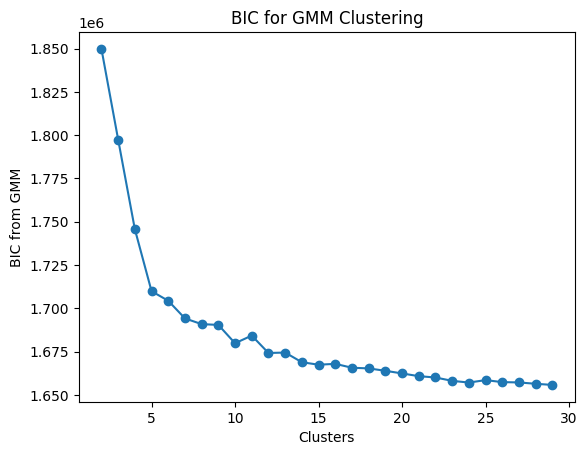

In [27]:
## ## RUNTIME: 30-60 min !!!












## DONT CHANGE below !!!










import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install rasterio
import rasterio
from sklearn.mixture import GaussianMixture



n_components = range(2, 30)
bic_scores = []
# aic_values = []



valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_m)

    bic_scores.append(gmm.bic(scaled_m))
    # aic_values.append(gmm.aic(scaled_m))


# relative difference
relative_bic_diff = [(bic_scores[i-1] - bic_scores[i]) / abs(bic_scores[i-1])
                     for i in range(1, len(bic_scores))]
threshold = 0.01
optimal_clusters = next((i + 1 for i, diff in enumerate(relative_bic_diff) if diff < threshold), len(n_components))

print('Optimal number of clusters with GMM (relative difference method):', optimal_clusters)


N = np.arange(2, 30)
plt.plot(N, bic_scores, marker='o')
plt.xlabel('Clusters')
plt.ylabel('BIC from GMM')
plt.title('BIC for GMM Clustering')
plt.show()

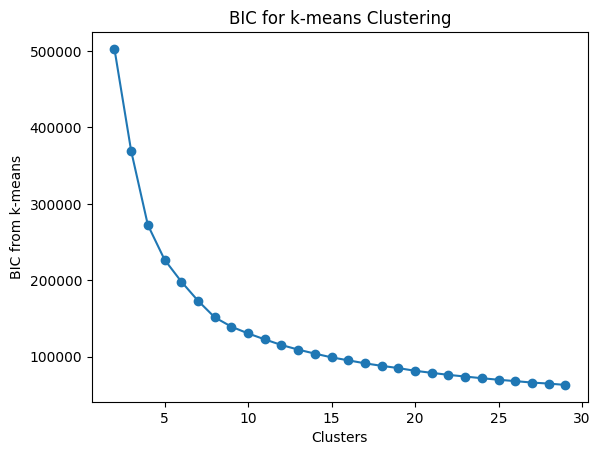

In [28]:
## RUNTIME: 30-60 min !!!




n_components = range(2, 30)  # Testing 2 to 30 Cluster (you can start with 15 and see if that is maybe already enough for testing)





## DONT CHANGE below !!!










from sklearn.cluster import KMeans


valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


def kmeans_bic(fit):
    m = fit.cluster_centers_.shape[1]
    n = len(fit.labels_)
    k = fit.n_clusters
    D = fit.inertia_
    return D + np.log(n) * m * k


bic_k = [
    kmeans_bic(
        KMeans(n_clusters=k, n_init=42, max_iter=25, random_state=42).fit(scaled_m)
    )
    for k in n_components
]


plt.plot(n_components, bic_k, marker='o')
plt.xlabel('Clusters')
plt.ylabel('BIC from k-means')
plt.title('BIC for k-means Clustering')
plt.show()


#https://bgstieber.github.io/post/an-introduction-to-the-kmeans-algorithm/

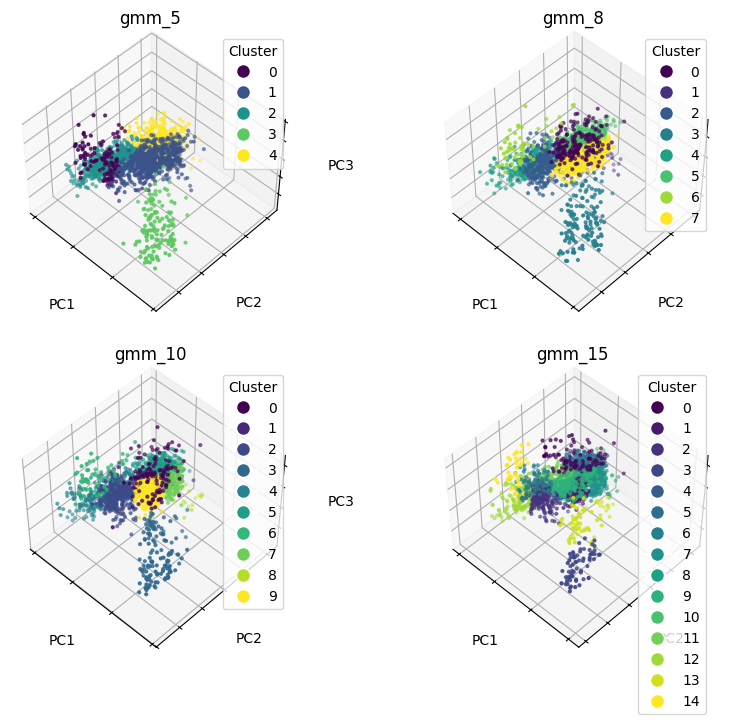

In [96]:
n_list = [5,8,10,15] # change here the number of clusters to be looked at

#selecting dimensions to look at
dim_x = 0  # Changed to a valid index (0 for pc1)
dim_y = 1  # Changed to a valid index (1 for pc2)
dim_z = 2  # Changed to a valid index (2 for pc3)










## DONT CHANGE below !!!!






import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


estimators = [
    (f"gmm_{n}", GaussianMixture(n_components = n, random_state=42))
    for n in n_list
]

titles = [f"gmm_{n}" for  n in n_list]






fig = plt.figure(figsize=(10, 8))


for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(scaled_m)
    labels = est.predict(scaled_m)

    sample_size = 2000

    sample_indices = np.random.choice(len(scaled_m), sample_size, replace=False)
    sampled_data = scaled_m[sample_indices]
    sampled_labels = labels[sample_indices]


    unique_labels = np.unique(sampled_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'{label}')
    for i, label in enumerate(unique_labels)]


    ax.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labels,cmap='viridis', s=4)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel(f"PC{dim_x+1}") # Updated label to reflect PC number
    ax.set_ylabel(f"PC{dim_y+1}") # Updated label to reflect PC number
    ax.set_zlabel(f"PC{dim_z+1}") # Updated label to reflect PC number
    ax.set_title(title)
    ax.legend(handles=legend_handles, title="Cluster")

K-means vs. GMM

Here we can compare GMM and Kmeans with a chosen number of cluster. Set that number in "chosen_cluster" and run. Then run the following two snippets to compare visually the models in 2D and interactive 3D.

In [30]:
#choose your cluster N to be compared between Kmeans and GMM
chosen_cluster = 8





## DONT CHANGE below !!












## data prep and model fitting

valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


sample_size = 2000
sample_indices = np.random.choice(len(scaled_m), sample_size, replace=False)
sampled_data = scaled_m[sample_indices]


gmm = GaussianMixture(n_components = chosen_cluster, random_state=42).fit(scaled_m)
labelsgmm = gmm.predict(scaled_m)
sampled_labelsgmm = labelsgmm[sample_indices]


kmeans = KMeans(n_clusters=chosen_cluster, random_state=42).fit(scaled_m)
labelsk = kmeans.labels_
sampled_labelsk = labelsk[sample_indices]


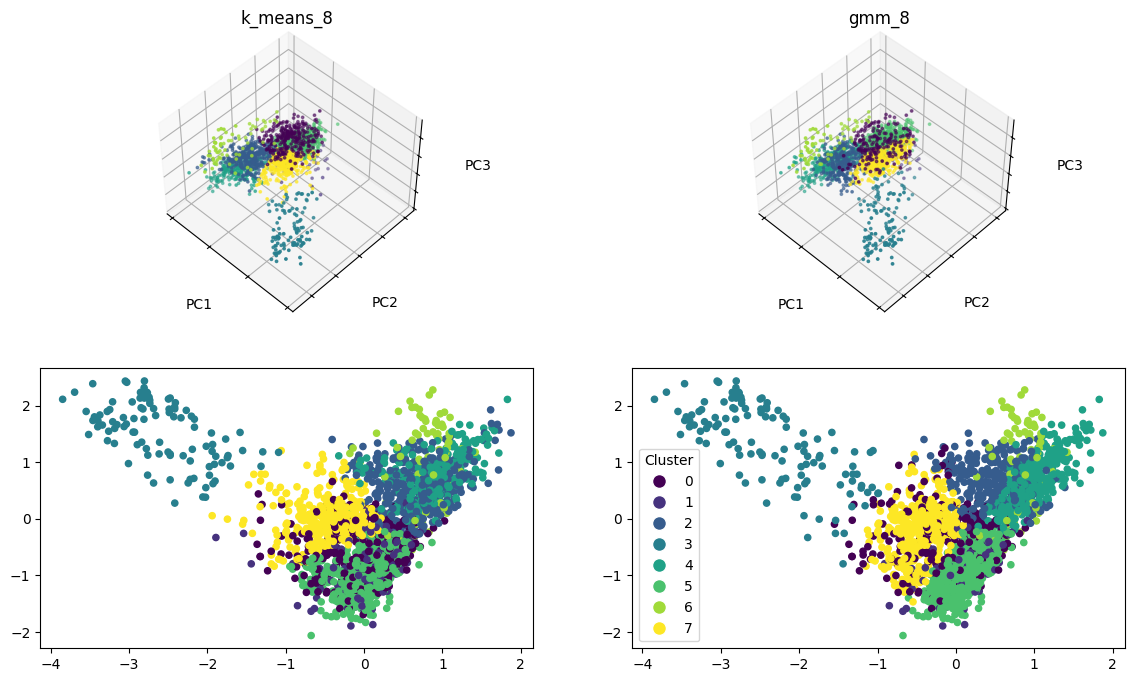

In [31]:
#selecting dimensions to look at
dim_x = 0#3
dim_y = 1#6
dim_z = 2#4







## DONT CHANGE below !!











import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap


fig = plt.figure(figsize=(14, 8))

titles = [f"k_means_{chosen_cluster}", f"gmm_{chosen_cluster}"]

unique_labels = np.unique(sampled_labelsk)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'{label}')
    for i, label in enumerate(unique_labels)
]


ax1 = fig.add_subplot(2, 2, 1, projection="3d", elev=48, azim=134)
ax1.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labelsk,cmap='viridis',s=3)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.zaxis.set_ticklabels([])
ax1.set_xlabel(f"PC{dim_x+1}")
ax1.set_ylabel(f"PC{dim_y+1}")
ax1.set_zlabel(f"PC{dim_z+1}")
ax1.set_title(titles[0])



ax2 = fig.add_subplot(2, 2, 2, projection="3d", elev=48, azim=134)
ax2.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labelsgmm, cmap='viridis',s=3)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.zaxis.set_ticklabels([])
ax2.set_xlabel(f"PC{dim_x+1}")
ax2.set_ylabel(f"PC{dim_y+1}")
ax2.set_zlabel(f"PC{dim_z+1}")
ax2.set_title(titles[1])


ax3 = fig.add_subplot(2,2,3)
ax3.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], c=sampled_labelsk, cmap='viridis', s=20)
# ax3.scatter(centers[:,2], centers[:,4], c='red', marker='x', s=100, label='Cluster Centers')
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], c=sampled_labelsgmm, cmap='viridis', s=20)
ax4.legend(handles=legend_handles, title="Cluster")
# ax4.scatter(centers[:,2], centers[:,4], c='red', marker='x', s=100, label='Cluster Centers')


plt.show()

3D interactive for GMM:

In [32]:
#selecting dimensions to look at
dim_x = 0#3
dim_y = 1#6
dim_z = 2#4






## DONT CHANGE BELOW !!!!









import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import plotly.express as px

x = sampled_data[0:,dim_x]
y = sampled_data[0:,dim_y]
z = sampled_data[0:,dim_z]



#gmm
dfgmm = pd.DataFrame({
    f'Dimension {dim_x}': x,
   f'Dimension {dim_y}': y,
    f'Dimension {dim_z}': z,
    'Cluster Label': sampled_labelsgmm
})

dfgmm["Cluster Label"] = dfgmm["Cluster Label"].astype("str")

category_orders = {"Cluster Label": [str(i) for i in range(chosen_cluster)]}



fig = px.scatter_3d(dfgmm, x = f'Dimension {dim_x}', y = f'Dimension {dim_y}', z = f'Dimension {dim_z}', color = 'Cluster Label', opacity=0.7, category_orders = category_orders, title =f"GMM{chosen_cluster} Clusters")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(size=4))
fig.show()

For Kmeans:

In [34]:
#selecting dimensions to look at
dim_x = 0#3
dim_y = 1#6
dim_z = 2#4





## DONT CHANGE below !!










import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import plotly.express as px




x = sampled_data[0:,dim_x]
y = sampled_data[0:,dim_y]
z = sampled_data[0:,dim_z]



#kmeans
dfkmeans = pd.DataFrame({
    f'Dimension {dim_x}': x,
   f'Dimension {dim_y}': y,
    f'Dimension {dim_z}': z,
    'Cluster Label': sampled_labelsk
})

dfkmeans["Cluster Label"] = dfkmeans["Cluster Label"].astype("str")

category_orders = {"Cluster Label": [str(i) for i in range(chosen_cluster)]}



fig1 = px.scatter_3d(dfkmeans, x = f'Dimension {dim_x}', y = f'Dimension {dim_y}', z = f'Dimension {dim_z}', color = 'Cluster Label', opacity=0.7, category_orders = category_orders)
fig1.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig1.update_traces(marker=dict(size=4))

fig1.show()

Final model to be used & preparation for export

After having decided on a cluster number you will run your preferred model now again. Set your cluster/CLZ number as "chosen_n" in the top of the code below.

FYI: your array contains missing values. The cluster number for the models is set to 11 clusters (10 for data + 1 for missing values).


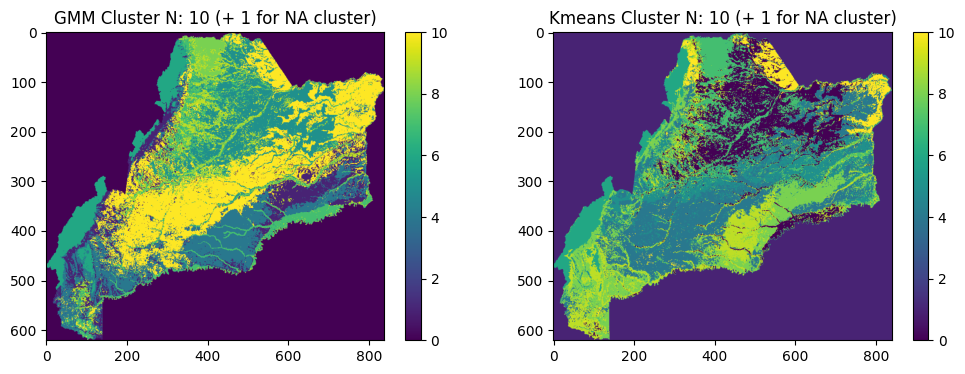

In [97]:
chosen_n = 10



## DONT CHANGE below !!!







from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np # Import numpy for checking for 9999

# Check for missing values (represented by 9999)
has_missing_values = 9999 in scaled

# Adjust chosen_n if missing values are present, and inform the user
initial_chosen_n = chosen_n
if has_missing_values:
    chosen_n = initial_chosen_n + 1
    print(f'FYI: your array contains missing values. The cluster number for the models is set to {chosen_n} clusters ({initial_chosen_n} for data + 1 for missing values).')
else:
    print(f'The cluster number for the models is set to {chosen_n}.')


## GMM
gmm = GaussianMixture(n_components = chosen_n, random_state=2025).fit(scaled) #change n_components depending on desicion
labelsgmm = gmm.predict(scaled) #predicting


## or Kmeans
# Add n_init='auto' or an explicit number like 10 to suppress the warning
kmeans = KMeans(n_clusters= chosen_n, random_state=42, n_init='auto').fit(scaled)
labelskm = kmeans.labels_


# now we convert the GMM output back to an array that we can map

#first we check again how our data looked like before the reshaping we did for the cluster tendency test

# print('We need that shape: ', himg_np.shape) # we need that shape
# print('Our current shape:', scaled.shape)


neededshape =  himg_np.shape
newshape = neededshape[:2]
# print(newshape)

clusteredimg_gmm = labelsgmm.reshape(newshape) # back to 3d #for los llanos: 611, 838,
clusteredimg_kmeans= labelskm.reshape(newshape) # back to 3d #for los llanos: 611, 838,

# print('Shape after transforming: ',clusteredimg_gmm.shape)


#plotting

import matplotlib as mpl
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)



if has_missing_values:

# Plot the first map on ax1
  img1 = ax1.imshow(clusteredimg_gmm, aspect='auto')
  ax1.set_title(f"GMM Cluster N: {initial_chosen_n} (+ 1 for NA cluster)")
  plt.colorbar(img1, ax=ax1)

  # Plot the second map on ax2
  img2 = ax2.imshow(clusteredimg_kmeans, aspect='auto')
  ax2.set_title(f"Kmeans Cluster N: {initial_chosen_n} (+ 1 for NA cluster)")
  plt.colorbar(img2, ax=ax2)
  plt.show()

else:

# Plot the first map on ax1
  img1 = ax1.imshow(clusteredimg_gmm, aspect='auto')
  ax1.set_title(f"GMM Cluster N: {chosen_n}")
  plt.colorbar(img1, ax=ax1)

  # Plot the second map on ax2
  img2 = ax2.imshow(clusteredimg_kmeans, aspect='auto')
  ax2.set_title(f"Kmeans Cluster N: {chosen_n}")
  plt.colorbar(img2, ax=ax2)

  plt.show()

You can export the arrays (clustered_img_kmeans & clusteredimg_gmm) as tiff. You will then upload it to your drive.

In [100]:
from rasterio.transform import from_origin
import numpy as np # Import numpy for data type

def export_array_to_geotiff(exportingarray, output_file, lon, lat, res):
    """
    exportingarray: 2D numpy array (rows x cols)
    output_file: str, path to save the geotiff
    lon, lat: top-left corner coordinates
    res: pixel size
    """
    # Define affine transform
    transform = from_origin(lon, lat, res, res)

    # Ensure data type is compatible, e.g., float32 or int32
    if exportingarray.dtype != np.float32 and exportingarray.dtype != np.int32:
        print(f"Warning: Changing array dtype from {exportingarray.dtype} to float32 for export compatibility.")
        exportingarray = exportingarray.astype(np.float32)


    # Define metadata
    new_dataset = rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=exportingarray.shape[0],
        width=exportingarray.shape[1],
        count=1,
        dtype=str(exportingarray.dtype),
        crs='EPSG:4326',  # Explicitly set CRS
        transform=transform,
    )
    new_dataset.write(exportingarray, 1)
    new_dataset.close()

In [101]:
import rasterio
import numpy as np # Import numpy for data type

# Define the path to your clustered tiff in your drive
raster_path = "/content/drive/MyDrive/Clustered_Rasters/gmm_15_cluster_llanos_fixed.tif"

# === Get georeferencing info from your input raster ===
with rasterio.open(raster_path) as src:
    transform = src.transform
    res = transform[0]               # pixel size
    lon, lat = transform[2], transform[5]   # top-left corner coordinates

# === Export GMM clusters ===
output_file_gmm = "/content/drive/MyDrive/Clustered_Rasters/gmm_clusters.tif"
export_array_to_geotiff(
    clusteredimg_gmm,
    output_file=output_file_gmm,
    lon=lon,
    lat=lat,
    res=res
)

# === Export KMeans clusters ===
output_file_kmeans = "/content/drive/MyDrive/Clustered_Rasters/kmeans_clusters.tif"
export_array_to_geotiff(
    clusteredimg_kmeans,
    output_file=output_file_kmeans,
    lon=lon,
    lat=lat,
    res=res
)

print(f"✅ Export complete!\nGMM saved to: {output_file_gmm}\nKMeans saved to: {output_file_kmeans}")

✅ Export complete!
GMM saved to: /content/drive/MyDrive/Clustered_Rasters/gmm_clusters.tif
KMeans saved to: /content/drive/MyDrive/Clustered_Rasters/kmeans_clusters.tif


Boundary Line Analysis (BLA)

1.   List item
2.   List item


Now that you have extracted the cluster numbers for each sample point and saved the updated shapefile, you can proceed with the Boundary Line Analysis. This analysis typically involves examining the relationship between your SOC data and the generated clusters.

The next cell is necessary because the output raster uses pixel based coordinates, causing the samples not to overlap with the data because of the difference in the coordinate system....Thus, there was need to transform and clip the raster to the aoi for correct overlapping

Sample points export task started. Check your Google Drive (/content/drive/MyDrive/ee-exports/carbon_stock_samples.geojson) for the GeoJSON file.
Llanos AOI export task started. Check your Google Drive (/content/drive/MyDrive/ee-exports/llanos_aoi.geojson) for the GeoJSON file.
Please wait for both export tasks to complete before proceeding.
Sample points GeoJSON file read successfully.
Llanos AOI GeoJSON file read successfully.
Sample points and Llanos AOI reprojected to EPSG:4326.
Original sample points count: 963
Sample points count after clipping to Llanos AOI: 963
Column names of your samples:  ['id', 'LAT_DD', 'LON_DD', 'STOCK0_30', 'geometry']


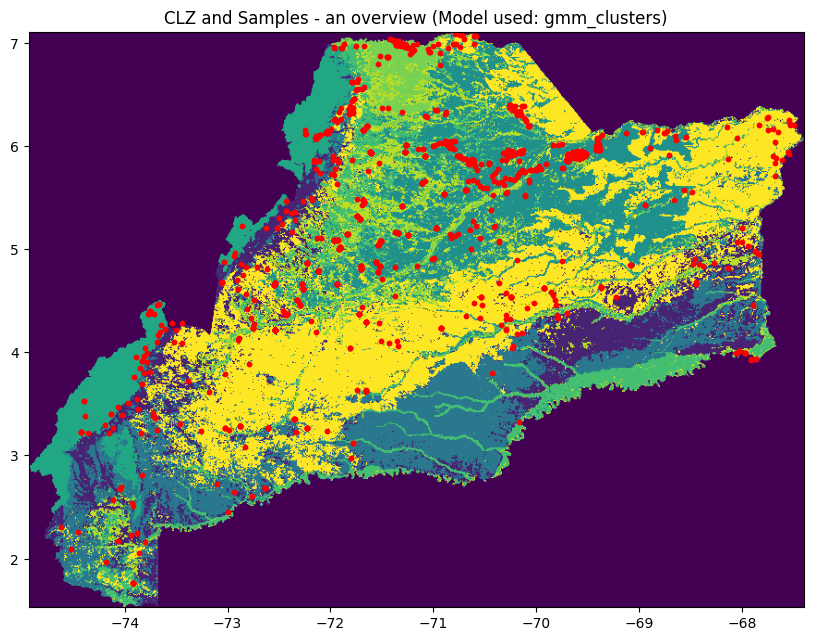

In [102]:
## defining your paths for shapefile and tiffs and your SOC-column


raster_path = "/content/drive/MyDrive/Clustered_Rasters/gmm_clusters.tif" #change your path to your clustered tiff in your drive (via google colab)



soc_column = "STOCK0_30"             #change to your soc column for the BLA





## DONT CHANGE Below !!!








import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import tifffile as tiff
import os
import geopandas as gpd # Import geopandas
import ee # Import Earth Engine
# from rasterio.sample import sample_gen # Comment out sample_gen

modelused = os.path.splitext(os.path.basename(raster_path))[0]

##reading files

# Use the Earth Engine asset path for the shapefile containing sample points
stock_soc_shp = ee.FeatureCollection('projects/ee-bejidedavid/assets/Carbon_stock')

# Use the Earth Engine asset path for the AOI shapefile (llanos_shp)
llanos_shp_ee = ee.FeatureCollection('projects/ee-bejidedavid/assets/Departamentos_Orinoquia_WGS84')


# Export the sample points FeatureCollection to a GeoJSON file in Google Drive
output_samples_geojson_path = '/content/drive/MyDrive/ee-exports/carbon_stock_samples.geojson' # Define an output path in your Drive

# Create the export task for sample points
task_samples = ee.batch.Export.table.toDrive(
    collection=stock_soc_shp,
    description='carbon_stock_samples_export',
    folder='ee-exports', # Folder in your Drive
    fileNamePrefix='carbon_stock_samples',
    fileFormat='GeoJSON'
)

# Start the export task for sample points
task_samples.start()

print(f"Sample points export task started. Check your Google Drive ({output_samples_geojson_path}) for the GeoJSON file.")


# Export the llanos_shp FeatureCollection to a GeoJSON file in Google Drive
output_llanos_geojson_path = '/content/drive/MyDrive/ee-exports/llanos_aoi.geojson' # Define an output path in your Drive

# Create the export task for llanos_shp
task_llanos = ee.batch.Export.table.toDrive(
    collection=llanos_shp_ee,
    description='llanos_aoi_export',
    folder='ee-exports', # Folder in your Drive
    fileNamePrefix='llanos_aoi',
    fileFormat='GeoJSON'
)

# Start the export task for llanos_shp
task_llanos.start()

print(f"Llanos AOI export task started. Check your Google Drive ({output_llanos_geojson_path}) for the GeoJSON file.")

print("Please wait for both export tasks to complete before proceeding.")


# This part should be run AFTER both export tasks are finished.
# For demonstration, I'll keep the reading and processing code here, but be aware it will fail if the exports are not done.

try:
    # Read the exported sample points GeoJSON file with GeoPandas
    samples = gpd.read_file(output_samples_geojson_path)
    print("Sample points GeoJSON file read successfully.")

    # Read the exported llanos_shp GeoJSON file with GeoPandas
    llanos_aoi_geo = gpd.read_file(output_llanos_geojson_path)
    print("Llanos AOI GeoJSON file read successfully.")

    # Reproject sample points and llanos AOI to EPSG:4326
    samples = samples.to_crs(epsg=4326)
    llanos_aoi_geo = llanos_aoi_geo.to_crs(epsg=4326)
    print("Sample points and Llanos AOI reprojected to EPSG:4326.")

    # Clip sample points to the llanos_aoi geometry
    samples_clipped = gpd.clip(samples, llanos_aoi_geo)
    print(f"Original sample points count: {len(samples)}")
    print(f"Sample points count after clipping to Llanos AOI: {len(samples_clipped)}")

    # Use the clipped samples for further processing
    samples = samples_clipped


    # aoi_r = tiff.imread(raster_path)
    # aoi_r = gdal.Open(raster_path)
    aoi_r = rasterio.open(raster_path)

    with rasterio.open(raster_path) as src:
      transform = src.transform



    ## first overview of your data and sample distribution

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(f"CLZ and Samples - an overview (Model used: {modelused})")

    # Plot the raster first
    show(aoi_r, ax=ax)
    # Then plot the samples on top
    samples.plot(ax=ax, color="red", markersize=10) # Added markersize for better visibility


    if samples.crs != src.crs:
        src = src.to_crs(samples.crs)

    column_names = list(samples.columns)
    print("Column names of your samples: ", column_names)

    ## extraction of rastervalues (cluster number/CLZ) for the samples
    # Alternative approach: loop through points and sample individually
    raster_values = []
    for index, row in samples.iterrows():
        try:
            # Get the pixel coordinates from the point geometry
            x, y = aoi_r.index(row.geometry.x, row.geometry.y)
            # Read the pixel value at the coordinates
            value = aoi_r.read(1)[x, y]
            raster_values.append(value)
        except Exception as e:
            print(f"Error sampling raster at point {index}: {e}")
            raster_values.append(np.nan) # Append NaN if sampling fails for a point


    samples['ClusterNumber'] = raster_values

    # Filter out samples where raster value is NaN (or a specific nodata value)
    samples = samples.dropna(subset=['ClusterNumber'])

    # Convert ClusterNumber to integer type if it's not already
    # This is important for grouping and plotting
    samples['ClusterNumber'] = samples['ClusterNumber'].astype(int)


    # plt.imshow(aoi_r.read(1))

except Exception as e:
    print(f"An error occurred while reading the GeoJSON file or processing data: {e}")
    print("Please ensure the Earth Engine export task has completed successfully.")

Here we start the BL where you can change the precentiles (e.g. ".80" for 80%). You will get a table and a plot to have a look on the results.

               count       mean        std        min        50%         80%  \
ClusterNumber                                                                  
0               14.0  53.840490  20.962133  16.243418  56.879924   70.398000   
1               74.0  55.462730  35.113033   9.815688  50.225000   74.802140   
2                2.0  40.315000  11.589480  32.120000  40.315000   45.232000   
4               41.0  66.258316  60.872917  14.825551  40.730089  105.390000   
5              323.0  58.986619  36.974609   3.457253  50.170000   81.806313   
6               65.0  72.063766  62.151322  10.947587  55.382875   95.616942   
7               74.0  50.054379  31.932057   9.940347  41.580000   67.550000   
8               50.0  52.346916  23.266155   9.781608  51.030000   65.084000   
9              124.0  50.450556  25.023711  13.025622  46.600000   64.506000   
10             196.0  59.440222  35.701169   6.928881  56.867353   82.982877   

                      85%         90%  

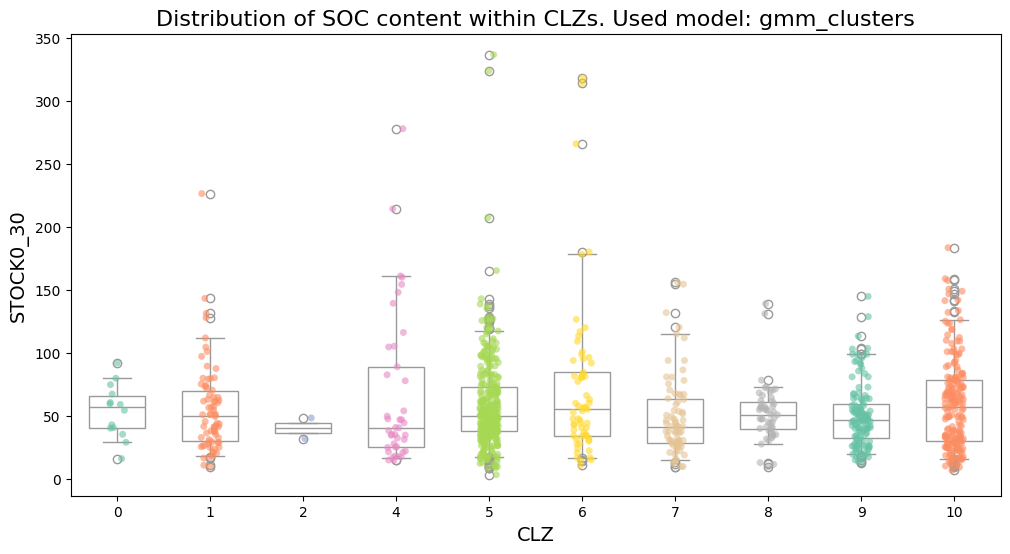

In [103]:
percentiles = [.80, .85, .90, .95] #change here the percentiles as eg. [.80, .85, .90, .95]



## DONT CHANGE below !!


# Check if 'ClusterNumber' column exists before proceeding
if 'ClusterNumber' not in samples.columns:
    print("Warning: 'ClusterNumber' column not found in the samples DataFrame. Adding a placeholder column. Please ensure that cell VgWQLtAHRrRw executed successfully and the raster values were extracted for meaningful results.")
    samples['ClusterNumber'] = -1 # Add a placeholder column

# Now proceed with grouping and plotting, which should not raise a KeyError
grouped_descriptions = samples.groupby('ClusterNumber')[soc_column].describe(percentiles=percentiles)
print(grouped_descriptions)



import seaborn as sns
import matplotlib.pyplot as plt

# Plot erstellen
plt.figure(figsize=(12, 6))

# Boxplot
sns.boxplot(x='ClusterNumber', y=soc_column, color="white", data=samples, whis=[5, 95], width=0.6, showcaps=True)

# Stripplot mit Jitter
sns.stripplot(x='ClusterNumber', y=soc_column, hue='ClusterNumber', data=samples,
              jitter=True, palette='Set2', alpha=0.6, size=5, legend = False)

# Achsentitel hinzufügen
plt.xlabel('CLZ', fontsize=14)
plt.ylabel(soc_column, fontsize=14)
plt.title(f'Distribution of SOC content within CLZs. Used model: {modelused}', fontsize=16)

# Plot anzeigen
plt.show()

Here you can get an overview of the distribution of the SOC-content within your CLZ.

In [113]:
cluster_u95 = samples.groupby('ClusterNumber')[soc_column].quantile(0.95).reset_index().rename(columns={soc_column:'p95'})
print(cluster_u95)


   ClusterNumber         p95
0              0   84.230577
1              1  117.581000
2              2   47.690500
3              4  161.140000
4              5  119.231000
5              6  179.833015
6              7  116.996000
7              8   76.135853
8              9   99.028500
9             10  127.850102


<Axes: >

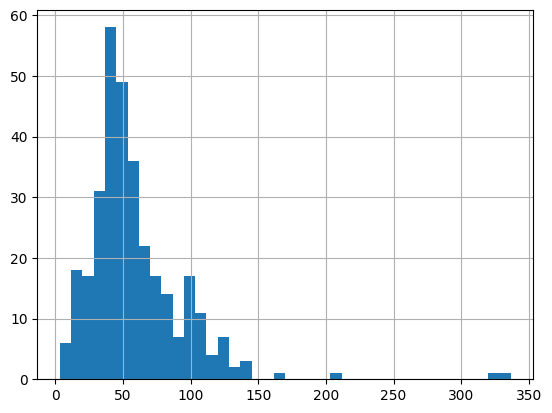

In [115]:
samples[samples["ClusterNumber"]==5][soc_column].hist(bins=40)


In [116]:
samples.groupby("ClusterNumber")[soc_column].count()


ClusterNumber
0      14
1      74
2       2
4      41
5     323
6      65
7      74
8      50
9     124
10    196
Name: STOCK0_30, dtype: int64

Finally you choose here which percentile you want to use for your final SOC potential calculation. In case you want to use all, you need to repeat this step and change the "chosen_percentil". This step also exports your final boundary line maximum SOC tif, if you like (set True or False in the function below).

The "chosen_percentil" is based on the list you made before the "percentiles"-list. In case you are not sure anymore on which you decided, you can run the code anyways and it prints you the list again. E.g.: [0.8, 0.85, 0.9, 0.95]. This list you have to index depending on which percentil you choose. Remember that python indexes with 0 as first position.

Your chosen percentils in a list:  [0.8, 0.85, 0.9, 0.95]
                      95%  Cluster
ClusterNumber                     
0               84.230577        0
1              117.581000        1
2               47.690500        2
4              161.140000        4
5              119.231000        5


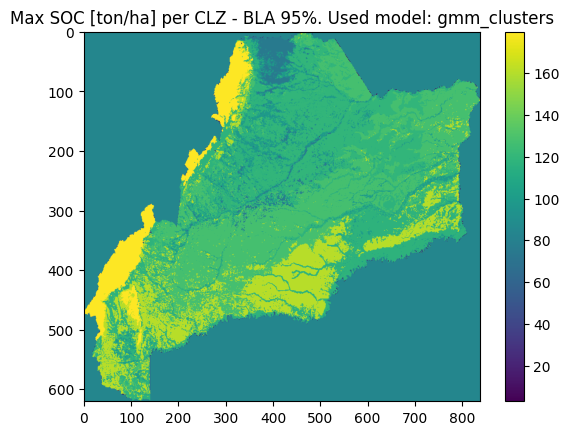

In [121]:
print("Your chosen percentils in a list: ", percentiles) #your list with the percentiles that we below will index


boundaryline(chosen_percentil=3, export = True)  # indexing in python starts with 0. So if you want the 3rd percentil in your list you will set 4 a chosen_percentil






In [123]:
import numpy as np
import rasterio

# Load cluster raster - Use the correct path to the file in Google Drive
with rasterio.open("/content/drive/MyDrive/Clustered_Rasters/gmm_clusters.tif") as src:
    cluster_raster = src.read(1)
    profile = src.profile

# Dictionary mapping cluster IDs -> BL max SOC
cluster_to_blmax = {
    0: 84.23,
    1: 117.5810,
    2: 47.690500,
    4: 161.140000,
    5: 119.231000,
    6: 179.833015,
    7: 116.996000,
    8: 76.135853,
    9: 99.028500,
    10:127.850102


    # add all clusters you keep
}

# Create BL max raster by mapping values
bl_max_raster = np.copy(cluster_raster).astype(float)
for cluster_id, bl_value in cluster_to_blmax.items():
    bl_max_raster[cluster_raster == cluster_id] = bl_value

# Save BL max SOC raster
profile.update(dtype="float32", count=1)
with rasterio.open("bl_max_soc.tif", "w", **profile) as dst:
    dst.write(bl_max_raster.astype("float32"), 1)

In [122]:
socbl = ee.Image("projects/ee-bejidedavid/assets/bl_max_soc")
socpot = socbl.clip(aoi).subtract(soc_stock_ee_clipped).max(0)


Your exported tifs have to uploaded now to your GEE account as Assets.

In [124]:
import ee

# Initialize Earth Engine (skip if already done)
# ee.Authenticate()
# ee.Initialize(project='ee-bejidedavid37')

# === Load images ===
socbl = ee.Image("projects/ee-bejidedavid/assets/bl_max_soc")   # BL Max SOC
soc_current = soc_stock_ee.clip(aoi)  # Current SOC from your earlier calculation

# === Clip BL max to AOI ===
socbl_clip = socbl.clip(aoi)

# === Calculate Potential SOC ===
soc_potential = socbl_clip.subtract(soc_current).max(0)  # ensures no negative values

# === Quick stats check ===
bl_stats = socbl_clip.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoi.geometry(),
    scale=30,
    maxPixels=1e13,
    bestEffort=True
).getInfo()

current_stats = soc_current.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoi.geometry(),
    scale=30,
    maxPixels=1e13,
    bestEffort=True
).getInfo()

pot_stats = soc_potential.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoi.geometry(),
    scale=30,
    maxPixels=1e13,
    bestEffort=True
).getInfo()

print("BL Max SOC (t/ha):", bl_stats)
print("Current SOC (t/ha):", current_stats)
print("Potential SOC (t/ha):", pot_stats)

# === Visualization (optional in geemap) ===
import geemap
Map = geemap.Map(center=[5, -72], zoom=6)  # adjust AOI center
vis = {"min": 0, "max": 200, "palette": ['#ffffcc','#a1dab4','#41b6c4','#225ea8']}
Map.addLayer(socbl_clip, vis, "BL Max SOC")
Map.addLayer(soc_current, vis, "Current SOC")
Map.addLayer(soc_potential, vis, "Potential SOC")
Map.addLayerControl()
Map

# === Export to Drive ===
folder = "GEE_Export"
task_potential = ee.batch.Export.image.toDrive(
    image=soc_potential,
    description="potential_soc_export",
    folder=folder,
    fileNamePrefix="potential_soc",
    region=aoi.geometry(),
    scale=30,
    crs="EPSG:4326",
    maxPixels=1e13
)
task_potential.start()
print("Potential SOC export task started. Check the EE Tasks tab.")

BL Max SOC (t/ha): {'b1_max': 179.8330078125, 'b1_min': 3}
Current SOC (t/ha): {'soc_stock_0_100_ton_ha_max': 187.49445576129472, 'soc_stock_0_100_ton_ha_min': 19.870976666668458}
Potential SOC (t/ha): {'b1_max': 158.2164138351544, 'b1_min': 0}
Potential SOC export task started. Check the EE Tasks tab.


Potential SOC content

Have a look on the current stock map if you like.

Looking at max and minimum values of the current stock SOC.

Now we import from GEE our maximum SOC content map. We calculate here the potential SOC content by subtracting the current SOC content map by the maximum SOC map from the Boundary Line Analysis. Make sure to have the same units (in this case ton/ha)

You can export the potential SOC content map now to your drive.

In [125]:
# map = geemap.Map()



map.addLayer(socblclip, vis_soc_tonha, "BL max SOC per Cluster")
map.addLayer(socpot, vis_soc_tonha, "Potential SOC per Cluster")


map

Map(bottom=16152.0, center=[5.834616165610059, -71.08154296875001], controls=(WidgetControl(options=['position…